In [2]:
import itertools

from tqdm.notebook import tqdm

import numpy as np

import scipy 
from scipy.sparse import diags
from scipy.linalg import toeplitz

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D

%matplotlib inline

In [2]:
def y_top(a, b):
    if a == 0:
        x = np.linspace(-b, b, 10000)
        y = np.sqrt(np.clip(b ** 2 - x ** 2, 0, np.inf))

        return x, y, None, None

    if a >= b:
        t = np.linspace(a + np.sqrt(a ** 2 - b ** 2), a + np.sqrt(a ** 2 + b ** 2), 1000)
        
        x_left = b ** 4 / 4 / a / t ** 2 - t ** 4 / 4 / a / t ** 2
        y_top_left = np.sqrt(np.clip(t ** 2 - (x_left - a) ** 2, 0, np.inf))
        
        x_right = -b ** 4 / 4 / a / t ** 2 + t ** 4 / 4 / a / t ** 2
        y_top_right = np.sqrt(np.clip(t ** 2 - (x_right + a) ** 2, 0, np.inf))

        return x_left, y_top_left, x_right, y_top_right
    
    else:
        t = np.linspace(-a + np.sqrt(a ** 2 + b ** 2), a + np.sqrt(a ** 2 + b ** 2), 1000)
    
        x = b ** 4 / 4 / a / t ** 2 - t ** 4 / 4 / a / t ** 2
        y_top = np.sqrt(np.clip(t ** 2 - (x - a) ** 2, 0, np.inf))
    
        return x, y_top, None, None


def get_oval(a1, a2, b):
    a = np.sqrt((a2.real - a1.real) ** 2 + (a2.imag - a1.imag) ** 2) / 2
    delta_x, delta_y = abs(a2.real + a1.real) / 2, abs(a2.imag + a1.imag) / 2
    
    
    cos, sin = ((a2.real - a1.real) / (2 * a), (a2.imag - a1.imag) / (2 * a)) if a else (1, 0)
    rot = np.array([[cos, sin], [-sin, cos]])
    
    x_l, y_l, x_r, y_r = y_top(a, b)
    x_l = np.concatenate((x_l, x_l))
    y_l = np.concatenate((y_l, -y_l))
    
    x_l, y_l = (list(zip(x_l, y_l)) @ rot).T
    x_l += delta_x
    y_l += delta_y
    
    if not x_r is None:
        x_r = np.concatenate((x_r, x_r))
        y_r = np.concatenate((y_r, -y_r))
    
        x_r, y_r = (list(zip(x_r, y_r)) @ rot).T
        x_r += delta_x
        y_r += delta_y
     
    return x_l, y_l, x_r, y_r

In [3]:
def get_gershgorin(A):
    circles, rg = [], []

    n = A.shape[0]
    xg, yg = np.diag(A).real, np.diag(A).imag

    for i in range(n):
        rg.append(np.sum(np.abs(A[i, :])) - np.abs(A[i, i]))
        circles.append(plt.Circle((xg[i], yg[i]), radius=rg[i], color='dimgrey', linewidth=1, alpha=None))
        
    return circles, np.array(rg)


def get_cassini(A):
    ovals = []
    
    n = A.shape[0]
    xg, yg = np.diag(A).real, np.diag(A).imag
    
    _, rg = get_gershgorin(A)
    
    for comb in itertools.combinations(range(n), 2):
        i, j = comb
        
        b = np.sqrt((rg[i] * rg[j]))
        a1, a2 = xg[i], xg[j]
        
        ovals.append(get_oval(a1, a2, b))
        
    return ovals


def get_melman(A):
    ovals = []
    
    n = A.shape[0]
    
    alpha = A[0][0]
    A_0 = A - np.eye(n) * alpha
    A_02 = A_0.dot(A_0)
    
    xg, yg = np.diag(A_02).real, np.diag(A_02).imag
    
    _, rg = get_gershgorin(A_02)
    
    for i in range(n):
        b = np.sqrt(rg[i])
        a1, a2 = alpha + np.sqrt(xg[i] + 1j * yg[i]), alpha - np.sqrt(xg[i] + 1j * yg[i])
        
        ovals.append(get_oval(a1, a2, b))
        
    return ovals

In [4]:
def Kostya(ax, x_l, y_l, x_r, y_r, color='darkgrey'):
    ax.fill(x_l, y_l, color=color) 
    if not x_r is None:
        ax.fill(x_r, y_r, color=color)
        

def plot_sets(A, ax, plot=['gamma', 'delta', 'omega']):
    handles = []
    if 'gamma' in plot:
        circles, _ = get_gershgorin(A)
        [ax.add_patch(circle) for circle in circles]
        
        handles.append(mpatches.Patch(color='dimgrey', label='Gershgorin'))
            
    if 'delta' in plot:
        ovals = get_cassini(A)
        [Kostya(ax, *oval) for oval in ovals]
        
        handles.append(mpatches.Patch(color='darkgrey', label='Brauer'))
        
    if 'omega' in plot:
        ovals = get_melman(A)
        [Kostya(ax, *oval, color='lightgrey') for oval in ovals]
        
        handles.append(mpatches.Patch(color='lightgrey', label='Melman'))
        
    
    ev = np.linalg.eigvals(A)
    ax.plot(ev.real, ev.imag, 'o', color='k', label="Eigenvalues")
    handles.append(Line2D([0], [0], color='white',marker='o', markerfacecolor='black', markersize=6, 
                          label='eigenvalues'))
    
    ax.axis('scaled')
    ax.legend(handles=handles, loc=1)

# Cassini Ovals and Their Applications

# 0. Motivation

Cassini's ovals are an area that contains eigenvalues. 
Cassini ovals are an important tool to estimate the spectrum of the matrix. With the help of spectrum estimation it is possible to accelerate methods such as the shifted inverse power method and the QR algorithm.

# I. Introduction

Consider the matrix:

$
\begin{bmatrix}
8      & -1 + i &   4 & -2  \\
-3 + i &     2i &   0 &  3  \\
0      &      1 &  -2 &  6i \\
-1     &     -2 &   1 &  5  \\
\end{bmatrix}
$

How can we localize it's eigenvalues?

### 1. Gershgorin Circles

$$A = (a_{ij})_{i,j=1}^{n}$$

$$R'_i(A) = \sum_{j=1, j \neq i}^n |a_{ii}|$$

$$\Gamma^R(A) = \bigcup_{i=1}^n \left\{z \in \mathbb{C}: |z - a_{ii}| \leq R'_i(A)\right\}$$

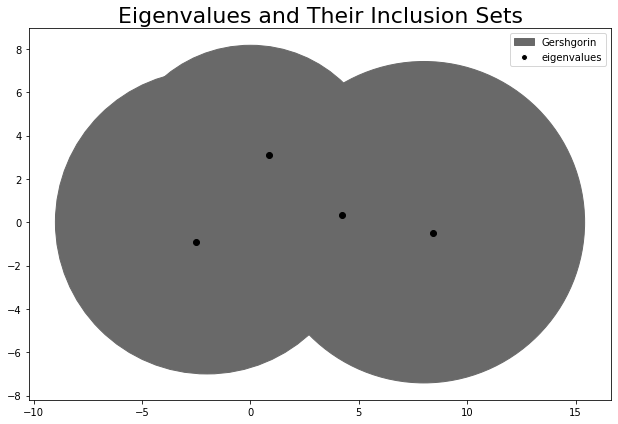

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
plt.title('Eigenvalues and Their Inclusion Sets', fontsize=22)


A = np.array([[      8, -1 + 1j,  4, -2], 
              [-3 + 1j,      2j,  0,  3], 
              [      0,       1, -2, 6j], 
              [     -1,      -2,  1,  5]])

plot_sets(A, ax, ['gamma'])

### 2. Cassini Ovals (Brauer Set)

$$\Delta^R(A) = \bigcup_{i\neq j}^n \left\{z\in \mathbb{C}: |z - a_{ii}||z - a_{jj}| \leq R'_i(A)R'_j(A)\right\}$$

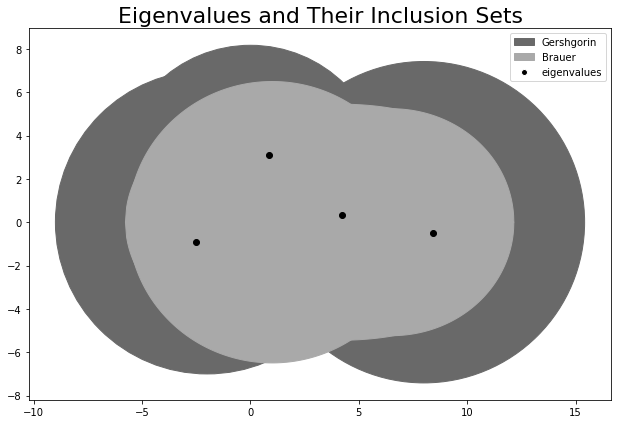

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
plt.title('Eigenvalues and Their Inclusion Sets', fontsize=22)


A = np.array([[      8, -1 + 1j,  4, -2], 
              [-3 + 1j,      2j,  0,  3], 
              [      0,       1, -2, 6j], 
              [     -1,      -2,  1,  5]])

plot_sets(A, ax, ['gamma', 'delta'])

Ok, but about the following matrix?
    
$
\begin{bmatrix}
2 & i  & -3 & -i \\
0 & 2  &  1 & -5 \\
4 & 1  &  2 &  2 \\
i & -1 &  1 &  2 \\
\end{bmatrix}
$

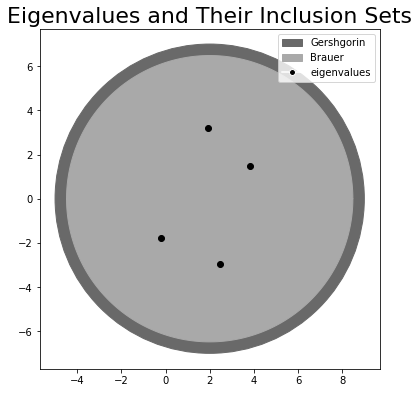

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
plt.title('Eigenvalues and Their Inclusion Sets', fontsize=22)

A = np.array([[ 2, 1j, -3, -1j], 
              [ 0,  2,  1, -5j], 
              [ 4,  1,  2,   2], 
              [1j, -1,  1,   2]])

plot_sets(A, ax, ['gamma', 'delta'])

### 3*. Cassini Ovals (Melman Set)

Cassini Ovals for matrices with constant main diagonal.

**Main idea:** form $A_0^2$ and utilize Gershgorin Theorem:

$$\Omega^R(A) = \bigcup_{i = 1}^n \left\{z\in \mathbb{C}: 
|z - \alpha - \sqrt{(A_0^2)_{ii}}||z - \alpha + \sqrt{(A_0^2)_{ii}}| \leq R'_i(A_0^2)\right\},$$

where $\alpha$ is the diagonal element and $A_0 = A - \alpha I$

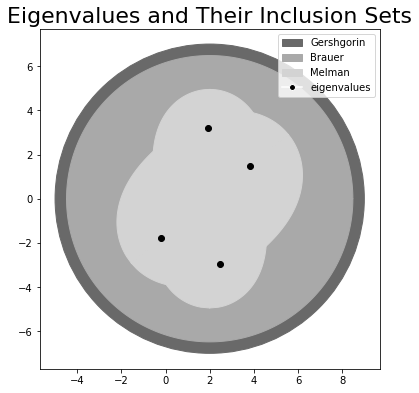

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
plt.title('Eigenvalues and Their Inclusion Sets', fontsize=22)

A = np.array([[ 2, 1j, -3, -1j], 
              [ 0,  2,  1, -5j], 
              [ 4,  1,  2,   2], 
              [1j, -1,  1,   2]])

plot_sets(A, ax)

Important class of matrices with constant main diagonal are Toeplitz matrices!

$ T =
\begin{bmatrix}
t_0       & t_1      & \dots  & t_{n - 1} \\
t_{-1}    & t_0      & \dots  & t_{n - 2} \\
\vdots    & \vdots   & \ddots & \vdots    \\
t_{1 - n} & t_{2 - n} & \dots  & t_0       \\
\end{bmatrix}
$

## II. Melman Set Properties

In [9]:
def get_matrix(a, b, c, N=5):
    z = int(np.floor((a) / 2))
    
    order_a = list(range(-z, z+1))
    order_b = sorted(np.random.choice(range(-int(np.ceil((N-1) * 0.5))-1, -z), size=b, replace=False))
    order_c = sorted(np.random.choice(range(z+1, int(np.ceil((N-1) * 0.5))+1), size=c, replace=False))
    
    order_ = sorted(order_a + order_b + order_c)
    
    m = np.random.randint(-10, 10, size=(len(order_))) + np.random.randint(-10, 10, size=(len(order_))) * 1j
    
    return diags(m, order_, shape=(N, N)).toarray()

def get_extremepoints(x_l, y_l, x_r, y_r):
    if x_r is None:
        return np.min(x_l), np.max(x_l), np.min(y_l), np.max(y_l)
    else:
        return [min(np.min(x_l), np.min(x_r)), 
                max(np.max(x_l), np.max(x_r)), 
                min(np.min(y_l), np.min(y_r)), 
                max(np.max(y_l), np.max(y_r))]

    
def get_rad(A, func):
    if func is get_gershgorin:
        rg = []
        n = A.shape[0]
        xg, yg = np.diag(A).real, np.diag(A).imag
        for i in range(n):
            rg.append(np.sum(np.abs(A[i, :])) - np.abs(A[i, i])) 
        rg = np.array(rg)
        left = np.min(xg - rg)
        right = np.max(xg + rg)
        bottom = np.min(yg - rg)
        top = np.max(yg + rg)
    else:
        ovals = func(A)
        left, right, bottom, top = get_extremepoints(*ovals[0])
        for oval in ovals:
            l, r, b, t = get_extremepoints(*oval)
            left = min(l, left)
            right = max(r, right)
            bottom = min(b, bottom)
            top = max(t, top)

    return max(top-bottom, right - left) / 2


def get_mu(A):
    ev = np.linalg.eigvals(A)
    x = np.real(ev)
    y = np.imag(ev)
    left, right, bottom, top = get_extremepoints(x, y, None, None)
    
    return max(top-bottom, right - left) / 2

### 1. Inclusion Sets for Random Band Matrices with a Constant Main Diagonal

Let us denote the radius of the disc containing $\Omega^{R}(A)$ and centred at $\alpha$ by $\rho_{\Omega}$
and the radius of the discs defining $\Gamma^{R}(A)$ and $\Delta^{R}(A)$ by $\rho_{\Gamma}$ and $\rho_{\Delta}$, respectively.

We also denote $\mu = \max_{1 \leq i \leq n} |\lambda_i - \alpha|$, where the $\lambda_i$’s are the eigenvalues of A and $\alpha$ is the constant diagonal element of A.

Then $$ \rho_{\Omega} \leq \rho_{\Delta} \leq \rho_{\Gamma}$$

In [10]:
matrices = (get_matrix(11, 3, 3, N=100), get_matrix(23, 16, 16, N=100), get_matrix(100, 0, 0, N=100))

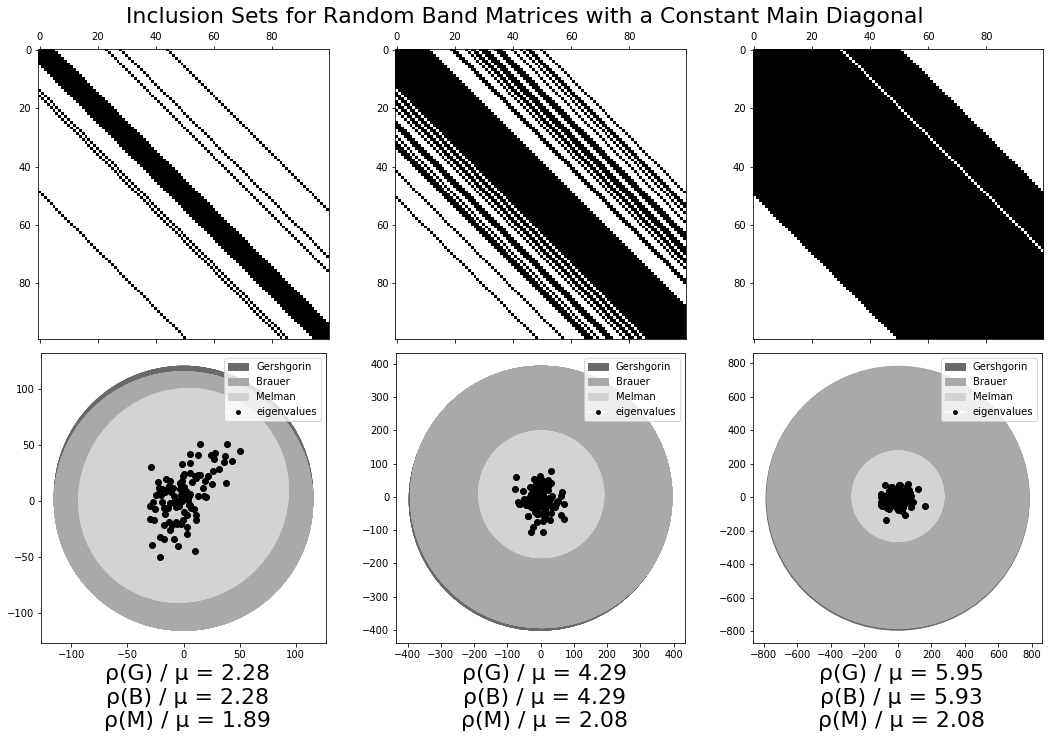

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
plt.suptitle('Inclusion Sets for Random Band Matrices with a Constant Main Diagonal', fontsize=22, y=1.02)
for i, A in tqdm(enumerate(matrices)):
    rho_gersh, rho_cassini, rho_melman = get_rad(A, get_gershgorin), get_rad(A, get_cassini), get_rad(A, get_melman)
    mu =  get_mu(A) 
    ax[0][i].spy(A)
    plot_sets(A, ax[1][i])
    ax[1][i].set_xlabel(f' ρ(G) / μ = {np.round(rho_gersh / mu, 2)}\n ρ(B) / μ = {np.round(rho_cassini / mu, 2)}\n ρ(M) / μ = {np.round(rho_melman / mu, 2)}', fontsize=22)

### 2. Toeplitz Matrices Dominated by Two Side Diagonals

When the absolute values of the elements in upper diagonal, symmetrically placed lower diagonal, dominate the absolute values of the other elements of the matrix. 


The square of such a matrix has a dominant main diagonal. Gershgorin’s discs give the best results for such matrices and since the  sets are based on them, we can expect them to work particularly well in these cases.

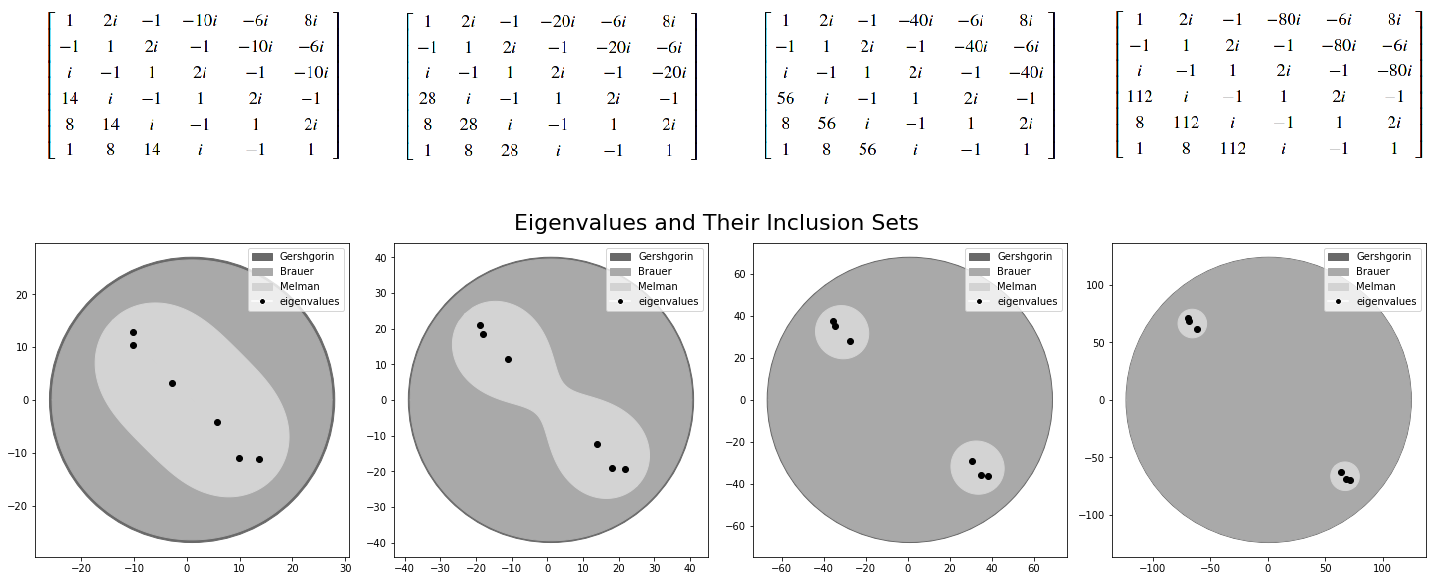

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), tight_layout=True)
fig.suptitle('Eigenvalues and Their Inclusion Sets', fontsize=22, y=.55)

for i in range(4):
    r = [1, 2j, -1, -10j * (2 ** i), -6j, 8j]
    c = [1, -1, 1j,   14 * (2 ** i),   8, 1j]
    
    A = toeplitz(c, r)
    ax[0][i].imshow(mpimg.imread(f'img/m{i+1}.png'))
    ax[0][i].axis('off')
    plot_sets(A, ax[1][i])

## III. Applications

### 0. Eigenvalue Spectrum Bounds Estimate

In [13]:
def get_nearest_melman(ovals):
    min_dist = np.inf
    min_point = 0
    for oval in ovals:
        x_l, y_l, x_r, y_r = oval[0], oval[1], oval[2], oval[3]

        i = np.argmin(np.linalg.norm(np.array([x_l, y_l]).T, axis=1))

        if np.linalg.norm(np.array([x_l, y_l]).T, axis=1)[i] < min_dist:
            min_dist = np.linalg.norm(np.array([x_l, y_l]).T, axis=1)[i]
            min_point = (x_l[i], y_l[i])

        if not x_r is None:
            j = np.argmin(np.linalg.norm(np.array([x_r, y_r]).T, axis=1))
            if np.linalg.norm(np.array([x_r, y_r]).T, axis=1)[j] < min_dist:
                min_dist = np.linalg.norm(np.array([x_r, y_r]).T, axis=1)[j]
                min_point = (x_r[j], y_r[j])

    return min_point, min_dist

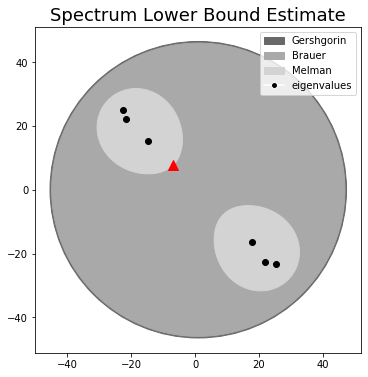

In [14]:
r, c = [1, 2j, -1, -10j*(2**1.3), -6j, 8j], [1, -1, 1j, 14*(2**1.3), 8, 1j]
A = toeplitz(c, r)

ovals = get_melman(A)
min_point, _ = get_nearest_melman(ovals)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_sets(A, ax)
plt.plot(*min_point, '^', markersize=10, color='red')
plt.title('Spectrum Lower Bound Estimate', fontsize=18)
plt.show()

### 1. Inverse Power Iteration

In [15]:
def power_method(A, N, sigma):
    res = np.zeros(N-1)
    l = 0 + 0 * 1j
    l_0 = 0 + 0 * 1j
    x_0 = np.ones(A.shape[0]) + np.ones(A.shape[0]) * 1j
    shift = np.linalg.inv(A - sigma * np.identity(A.shape[0]))
    x = x_0 / np.linalg.norm(x_0)
    for i in range(1, N):
        x = shift @ x
        x = x / np.linalg.norm(x)
        l = (x.conj().T @ A @ x) / (x.conj().T @ x)
        res[i-1] = np.linalg.norm(A @ x - l * x)
    return x, l, res

In [16]:
sigma = min_point[0] + min_point[1] * 1j

x, l, res = power_method(A, 50, sigma=sigma)
x_, l_, res_ = power_method(A, 50, sigma=0)

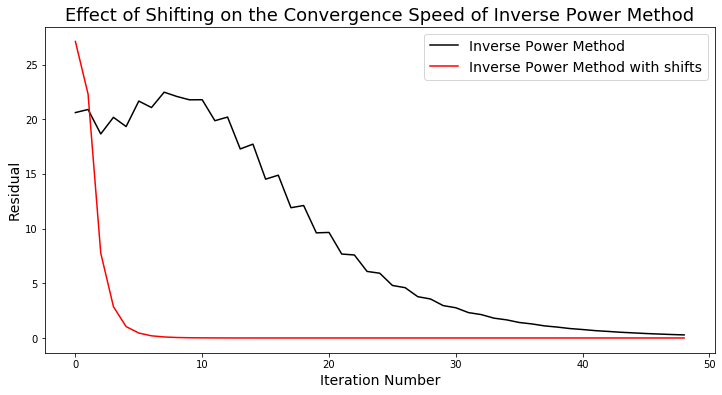

In [17]:
plt.figure(figsize=(12, 6))

plt.plot(res_, color='k', label='Inverse Power Method')
plt.plot(res, color='r', label='Inverse Power Method with shifts')

plt.title('Effect of Shifting on the Convergence Speed of Inverse Power Method', fontsize=18)
plt.ylabel('Residual', fontsize=14)
plt.xlabel('Iteration Number', fontsize=14)

plt.legend(fontsize=14)
plt.show()

### 2. QR Algorithm

In [18]:
def qr_shifts(A, s, num_iter):
    deltas = []

    if isinstance(s, (int, float, complex)) or len(s) == 1:
        s = np.array([s]*num_iter)
    if len(s) != num_iter:
        raise ValueError()
    Ak = A
    for i in range(num_iter):
        qk, rk = np.linalg.qr(Ak - s[i]*np.eye(A.shape[0]))
        Ak = rk.dot(qk) + s[i] * np.eye(A.shape[0])
        
        subdiag = scipy.linalg.triu(Ak.T).T
        for i in range(subdiag.shape[0]):
            subdiag[i, i] = 0
        delta = np.linalg.norm(subdiag, 2)
        deltas.append(delta)
    return Ak, deltas

In [19]:
r, c = [1, 2j, -1, -10j*(2**2), -6j, 8j], [1, -1, 1j, 14*(2**2), 8, 1j]
A = toeplitz(c, r)

In [20]:
num_iter = 200
lambdas = np.linalg.eigvals(A)

Ak, deltas = qr_shifts(A, (-22.089735034402896 + 23.0897350344029j), num_iter)
Ak_0, deltas_0 = qr_shifts(A, 0, num_iter)

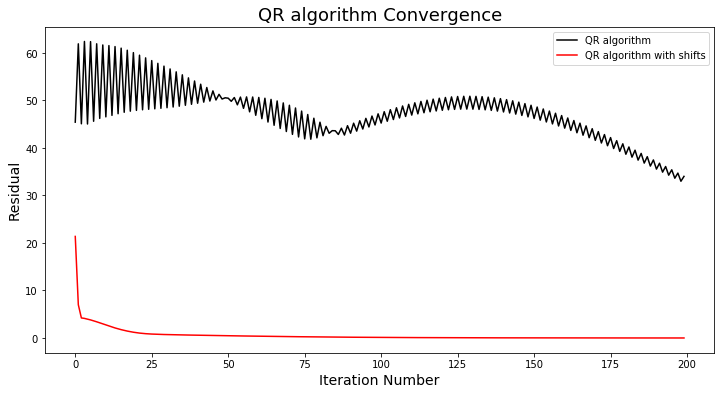

In [21]:
plt.figure(figsize=(12, 6))

plt.plot(deltas_0,  color='k', label='QR algorithm')
plt.plot(deltas,  color='r', label='QR algorithm with shifts')

plt.title('QR algorithm Convergence', fontsize=18)
plt.ylabel('Residual', fontsize=14)
plt.xlabel('Iteration Number', fontsize=14)

plt.legend()
plt.show()

## Conclusion

- Matrices with constant main diagonal are quite common, e.g. Toeplitz
- Gershgorin and Brauer sets does not show sufficient about the spectrum in this case
- Melman set as a solution
- Applications: Inverse Power Method and QR algorithm speed-up